In [366]:
import itertools
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import calendar
import pickle

In [401]:
path = r"C:/Users/TurnerJosh/Desktop/SensitiveData/GoodSalesData1.xlsx"
df = pd.read_excel(path)
df = df.sort_values('Invoice Date')
df1 = df.set_index('Invoice Date')
# df = df.loc[df['Charge Amount'] != 0]

In [403]:
df1['Charge Amount'].mean(),df1['Charge Amount'].var()

(2298.2450515105916, 35733451.99794235)

In [371]:
df1 = df1.loc[df1['Charge Amount'] != 0]
# df['Charge Amount'].plot(label='with zeros')
# df1['Charge Amount'].plot(c ='black',label='without zeros',alpha=0.4)
# plt.legend()

In [372]:
df1.shape

(4618, 9)

In [249]:
# number of unique dates
# DF = df.groupby(['Invoice Date','Charge Amount']).sum().reset_index()
# DF.columns

In [394]:
DF = df1['Charge Amount'].groupby(df1.index.to_period('D')).sum().copy()

In [337]:
# DF.index = pd.DatetimeIndex(DF.asfreq(freq='D'))

In [395]:
DF.index = DF.index.astype('datetime64[ns]')

In [396]:
DF.index

DatetimeIndex(['2017-09-26', '2017-12-12', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-26', '2018-01-29', '2018-02-07',
               '2018-02-08', '2018-02-09',
               ...
               '2023-07-13', '2023-07-14', '2023-07-17', '2023-07-18',
               '2023-07-19', '2023-07-20', '2023-07-21', '2023-07-24',
               '2023-07-25', '2023-07-26'],
              dtype='datetime64[ns]', name='Invoice Date', length=1510, freq=None)

In [388]:
DF.shape
# DF = DF.rename('ts')
DF.head(3)

Invoice Date
2017-09-26    5000
2017-12-12      12
2018-01-10    5017
Name: Charge Amount, dtype: int64

In [ ]:
# df['Charge Amount'].iloc[-30:].groupby(df['Invoice Date'].dt.to_period('d')).sum().plot(kind='bar')

In [ ]:
# first = DF.index.to_timestamp()[0]
# last = DF.index[-1].to_timestamp()
# cal = USFederalHolidayCalendar()
# hol = cal.holidays(start=first, end=last)
# DF.index.to_timestamp()

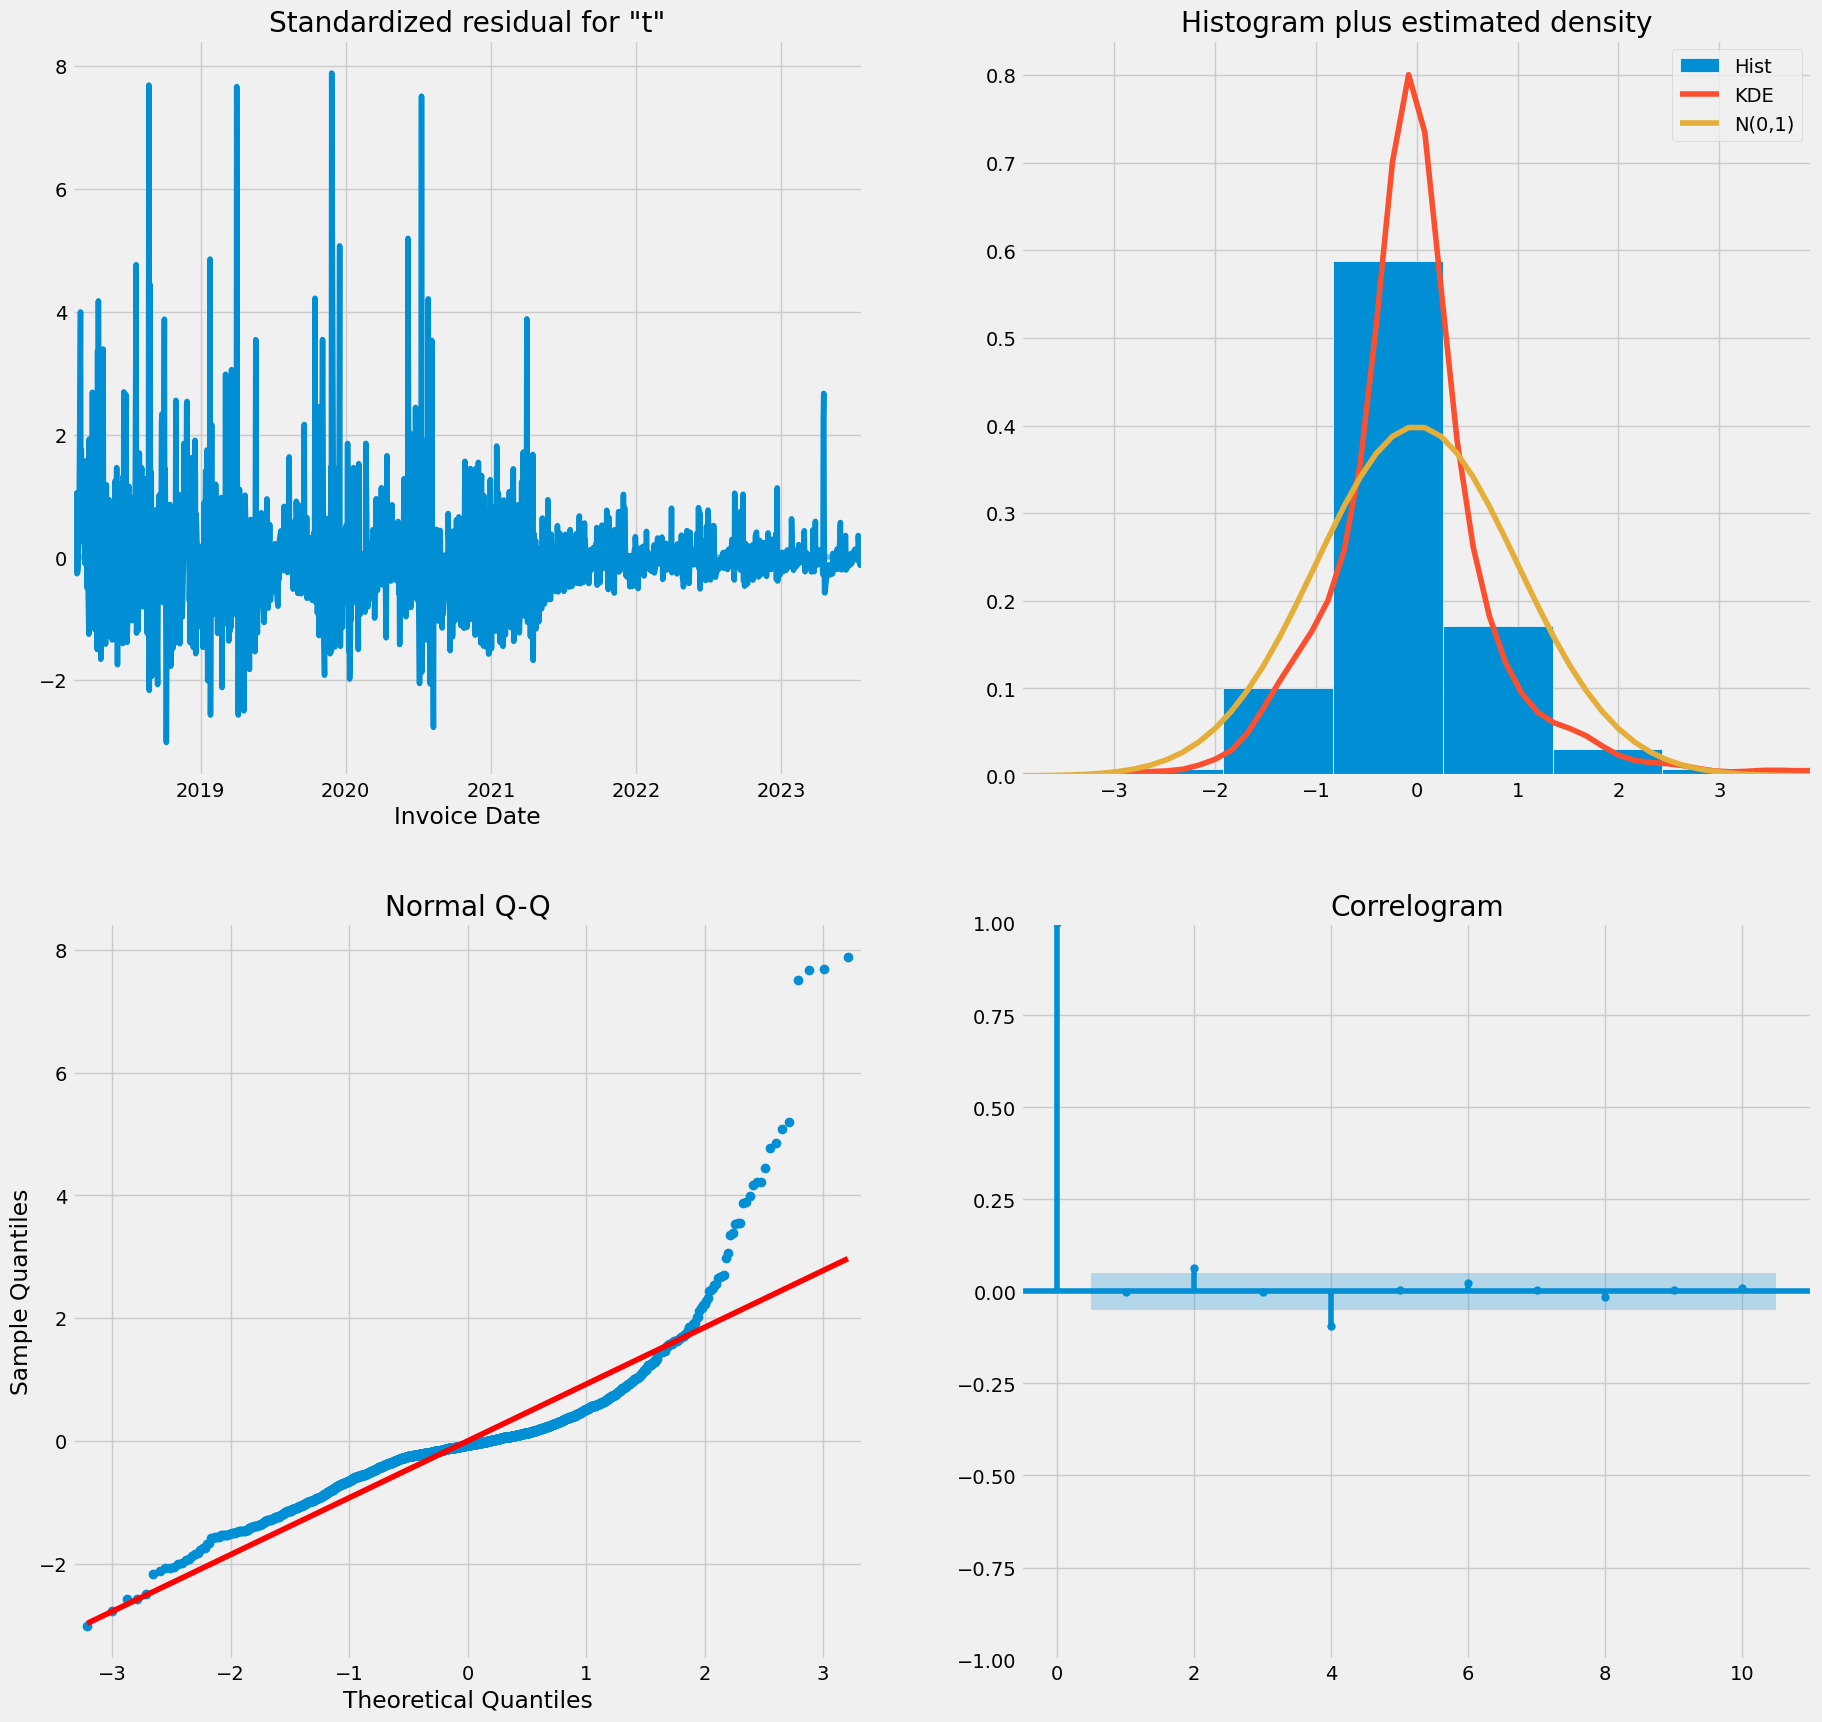

In [400]:
results.plot_diagnostics(figsize=(20, 20))
plt.show()

In [397]:
DF.index

DF['date'] = DF.index
DF['hour'] = DF['date'].dt.hour
DF.head(3)

AttributeError: 'DatetimeIndex' object has no attribute 'dt'

In [378]:

def create_features(df):
    """
    Creates time series features from datetime index
    """
    # df.index = pd.to_datetime(df.index)
    # df.index.to_timestamp()
   #  ix = df.index.to_timestamp()
   #  first = str(ix[0])
   #  last = str(ix[-1])
   #  cal = USFederalHolidayCalendar()
#     hol = cal.holidays(start=first, end=last)
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    # df['weekofyear'] = df['date'].weekofyear
#     df['isholiday'] = np.where(
   #  df.index.to_period('D').astype('datetime64[ns]').isin(hol),
   #     1, 0
   #     )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    return X

In [380]:
exog_df = create_features(DF)

AttributeError: 'DatetimeIndex' object has no attribute 'dt'

In [381]:
exog_df

Invoice Date
hour          Index([0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       .....
dayofweek     Index([1, 1, 2, 3, 4, 4, 0, 2, 3, 4,
       .....
quarter       Index([3, 4, 1, 1, 1, 1, 1, 1, 1, 1,
       .....
month         Index([ 9, 12,  1,  1,  1,  1,  1,  2,  2,  2,...
year          Index([2017, 2017, 2018, 2018, 2018, 2018, 201...
dayofyear     Index([269, 346,  10,  11,  12,  26,  29,  38,...
dayofmonth    Index([26, 12, 10, 11, 12, 26, 29,  7,  8,  9,...
weekofyear    Index([39, 50,  2,  2,  2,  4,  5,  6,  6,  6,...
Name: ts, dtype: object

In [230]:
ts = DF

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
aic = float('inf')
for es in [True,False]:
    for param in pdq:
      for param_seasonal in seasonal_pdq:
        try:
          mod = sm.tsa.statespace.SARIMAX(ts,
                                          exog = exog_df,
                                          order=param,
                                          seasonal_order=param_seasonal,
                                          enforce_stationarity=es,
                                          enforce_invertibility=False)
          results = mod.fit()
          if results.aic<aic:
            param1=param
            param2=param_seasonal
            aic=results.aic
            es1=es
          print('ARIMA{}x{} enforce_stationarity={} - AIC:{}'.format(param, param_seasonal,es,results.aic))
        except:
          continue
# Save the model to disk using pickle
# with open('arima_model.pkl', 'wb') as f:
#     pickle.dump(results, f)
print('Best model parameters: ARIMA{}x{} - AIC:{} enforce_stationarity={}'.format(param1, param2, aic,es1))
# Use optimal parameters to fit model
mod = sm.tsa.statespace.SARIMAX(ts,
                                order=param1,
                                seasonal_order=param2,
                                enforce_stationarity=es1,
                                enforce_invertibility=False)
results = mod.fit()
# pred_uc = results.get_forecast(steps=200)

# # pred_uc = results.get_forecast(steps=calendar.monthrange(datetime.now().year,datetime.now().month)[1]-datetime.now().day+1)
# pred_ci = pred_uc.conf_int()
# ax = ts.plot(label='observed', figsize=(12, 5))
# pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
# ax.set_xlabel('Date')
# plt.legend()
# plt.show()

# predict=pred_uc.predicted_mean.to_frame()
# # predict.reset_index(inplace=True)
# predict.rename(columns={'index': 'date',0: 'revenue_forcast'}, inplace=True)
# display(predict)

Best model parameters: ARIMA(1, 1, 1)x(1, 0, 1, 7) - AIC:inf enforce_stationarity=False


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

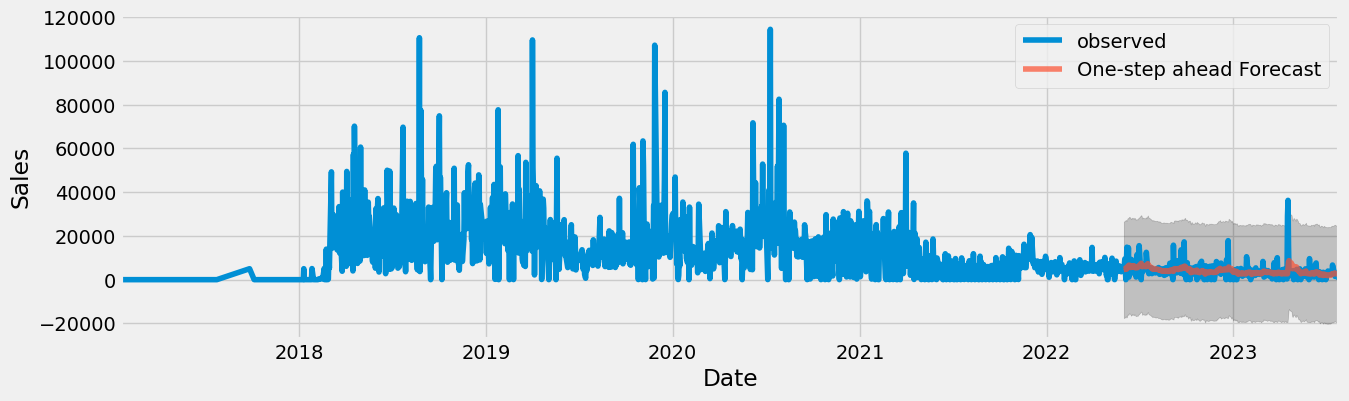

In [109]:
pred = results.get_prediction(start=pd.to_datetime('2022-06-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = ts.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [163]:
y_forecasted = pred.predicted_mean
y_truth = ts['2022-06-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 13075440.56
The Root Mean Squared Error is 3616.0


In [39]:
pred_uc1 = pred_uc.predicted_mean
pred_uc1.columns = ['predicted1','predicted2', 'predicted_n']
pred_uc1.head(5)

8639   -20.978935
8640   -31.864446
8641   -46.971165
8642   -13.530151
8643    47.094296
Name: predicted_mean, dtype: float64

In [32]:
pred_uc_ci = pred_uc.conf_int(alpha=0.05)

In [34]:
predict=pred_uc.predicted_mean.to_frame()
predict.reset_index(inplace=True)
predict.rename(columns={'index': 'date',0: 'revenue_forcast'}, inplace=True)
display(predict)

,date,revenue_forcast
0,8639,-20.978935


In [36]:
mod.forecast(steps=14)


AttributeError: 'SARIMAX' object has no attribute 'forecast'